# Modelo de clasificación de imágenes de lengua de señas en Español

## Librerías

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Redimensionar imágenes 

In [15]:
# import cv2

# input_folder = "./classes_original/"
# output_folder = "./classes/"
# new_size = (224, 224)

# for root, dirs, files in os.walk(input_folder):
#     relative_path = os.path.relpath(root, input_folder)
#     output_subfolder = os.path.join(output_folder, relative_path)
#     os.makedirs(output_subfolder, exist_ok=True)
#     for file in files:
#         input_path = os.path.join(root, file)
#         output_path = os.path.join(output_subfolder, file)
#         img = cv2.imread(input_path)
#         resized_img = cv2.resize(img, new_size)
#         cv2.imwrite(output_path, resized_img)

In [4]:
data_path = "./classes/"

def load_images(path):
    images = []
    labels = []
    classes = os.listdir(path)
    for class_name in classes:
        for file_name in os.listdir(os.path.join(path, class_name)):
            img_path = os.path.join(path, class_name, file_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = tf.keras.applications.mobilenet_v2.preprocess_input(img) 
            images.append(img)
            labels.append(class_name)
    return np.array(images), np.array(labels)

X, y = load_images(data_path)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
num_classes = len(np.unique(y_train))

In [11]:
import json
class_indices = {}
for i, class_name in enumerate(np.unique(y_train)):
    class_indices[class_name] = i
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

y_train = np.vectorize(class_indices.get)(y_train)
y_val = np.vectorize(class_indices.get)(y_val)
y_test = np.vectorize(class_indices.get)(y_test)


In [6]:
def create_model(kernel_size, num_layers, batch_size, learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), activation='relu', input_shape=(224, 224, 3)))
    for _ in range(num_layers - 1):
        model.add(tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
print(best_params)

{'batch_size': 32, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_layers': 3}


In [13]:
# param_grid = {
#     'kernel_size': [3, 5],
#     'num_layers': [2, 3],
#     'batch_size': [32, 64],
#     'learning_rate': [0.001, 0.0001]
# }
# param_grid = {
#     'kernel_size': [5],
#     'num_layers': [3],
#     'batch_size': [32],
#     'learning_rate': [0.0001]
# }

# model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# grid_result = grid.fit(X_train, y_train)

# best_params = grid_result.best_params_

 
best_params = {'batch_size': 32, 'kernel_size': 5, 'learning_rate': 0.0001, 'num_layers': 3}
final_model = create_model(**best_params)
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))


Epoch 1/10
44/44 [==============================] - 346s 8s/step - loss: 1.7691 - accuracy: 0.4750 - val_loss: 1.0315 - val_accuracy: 0.6667
Epoch 2/10
44/44 [==============================] - 337s 8s/step - loss: 0.5012 - accuracy: 0.8526 - val_loss: 0.6854 - val_accuracy: 0.8033
Epoch 3/10
44/44 [==============================] - 370s 8s/step - loss: 0.1174 - accuracy: 0.9714 - val_loss: 0.6284 - val_accuracy: 0.8300
Epoch 4/10
44/44 [==============================] - 326s 7s/step - loss: 0.0486 - accuracy: 0.9828 - val_loss: 0.6846 - val_accuracy: 0.8400
Epoch 5/10
44/44 [==============================] - 352s 8s/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.6882 - val_accuracy: 0.8367
Epoch 6/10
44/44 [==============================] - 325s 7s/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.7043 - val_accuracy: 0.8100
Epoch 7/10
44/44 [==============================] - 322s 7s/step - loss: 0.0118 - accuracy: 0.9979 - val_loss: 0.7121 - val_accuracy: 0.8467
Epoch 8/10
44

In [ ]:
final_model.save('model.h5')


In [2]:
## cargar el modelo y hacer predicciones con nuevas imagenes 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import os
import json

model = load_model('model.h5')

class_indices = json.load(open('class_indices.json'))

def predict_image(model, img_path, class_indices):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    prediction = model.predict(img)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]
    return predicted_class

img_path = "./classes_original/M/DSC01254.JPG"
predicted_class = predict_image(model, img_path, class_indices)
print(predicted_class)


1/1 [==============================] - 0s 372ms/step
M


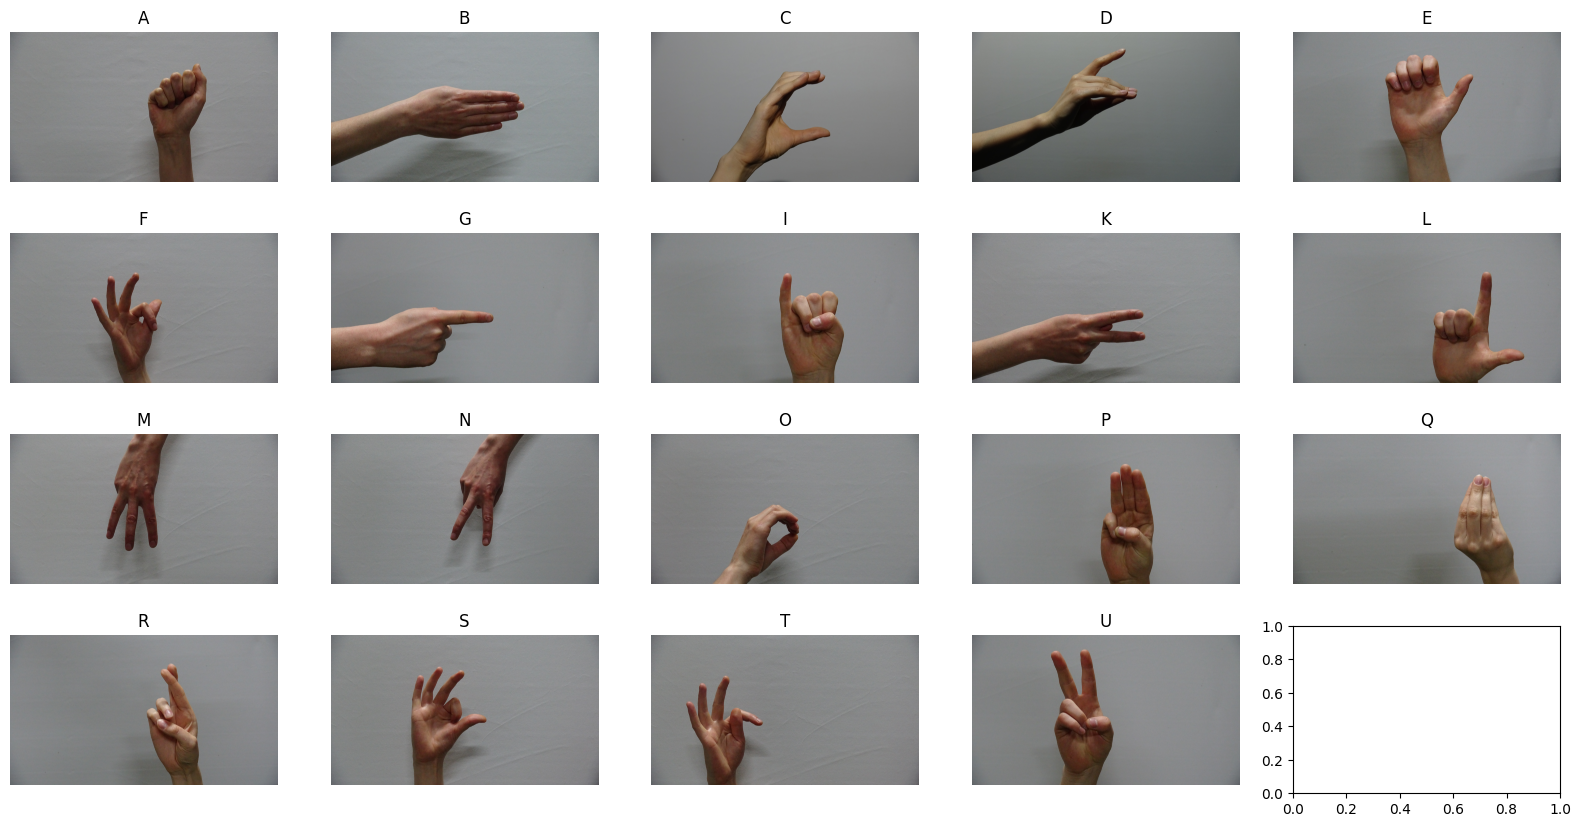

In [3]:
import matplotlib.pyplot as plt
import os
import random
import json
from tensorflow.keras.preprocessing import image

class_indices = json.load(open('class_indices.json'))
classes = list(class_indices.keys())
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for i in range(min(len(classes), 19)):
    class_name = classes[i]
    img_name = random.choice(os.listdir(f'./classes_original/{class_name}'))
    img_path = f'./classes_original/{class_name}/{img_name}'
    img = image.load_img(img_path)
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_title(class_name)
    axes[i//5, i%5].axis('off')
plt.show()


In [ ]:
# quiero que me haga predicciones en tiempo real con la camara
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json

model = load_model('model.h5')

class_indices = json.load(open('class_indices.json'))

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    img = cv2.resize(frame, (224, 224))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    prediction = model.predict(img)
    predicted_class = list(class_indices.keys())[np.argmax(prediction)]
    cv2.putText(frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()